# Setup

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans, AgglomerativeClustering
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
from collections import Counter
from pprint import pprint
import matplotlib.colors as mcolors
import matplotlib.collections as mcollections
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

## Setup

In [2]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
prices_df.index = pd.to_datetime(prices_df.index)
caps_df = pd.read_csv(cap_path, index_col='date')
caps_df.index = pd.to_datetime(caps_df.index)

In [3]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
caps_df = caps_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [4]:
print(len(train_df))
print(len(caps_df))

2894
2894


In [5]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10810
2467


## Sectors

In [6]:
Market_dict = {}
file_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/Nasdaq_sectors.csv'
nasdaq_sectors = pd.read_csv(file_path)
cols_to_keep = ['Symbol', 'Sector']
nasdaq_sectors = nasdaq_sectors[cols_to_keep]

In [7]:
for Sector in nasdaq_sectors['Sector'].unique().tolist():
    if pd.notna(Sector):
        Market_dict[Sector] = []
        temp_df = nasdaq_sectors[nasdaq_sectors['Sector']==Sector]
        for stk in temp_df['Symbol'].unique().tolist():
            if stk in complete_stock_list:
                Market_dict[Sector].append(stk)

In [8]:
for Sector in list(Market_dict.keys()):
    print(Sector)
    print(len(Market_dict[Sector]))

Industrials
343
Finance
430
Real Estate
101
Health Care
679
Consumer Discretionary
630
Technology
414
Basic Materials
19
Consumer Staples
75
Energy
100
Miscellaneous
24
Utilities
73
Telecommunications
35


In [9]:
full_market_dict = Market_dict

# Functions

## Clustering

In [27]:
def get_corr_matrix(DataFrame):
    #print()
    return DataFrame.corr()

In [11]:
def K_mean_clustering(DataFrame, num_clusters, n_init):
    #if (DataFrame.isnull().values.any()):
    #    print('Nan in Price')
    X = get_corr_matrix(DataFrame)
    #if (X.isnull().values.any()):
    #    print('Nan in Corr')
    #X = ((1-X)/2.)**.5 #distance matrix
    kmeans = KMeans(n_clusters=num_clusters, n_init=n_init).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [12]:
def spectral_clustering(df, num_clusters):
    A = abs(df.corr().values)
    #A = df.corr().values
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [13]:
def Hierarchical_clustering(df, num_clusters):
    X = get_corr_matrix(df)
    X = ((1-X)/2.)**.5 #distance matrix
    HC_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')
    labels = HC_clustering.fit(X).labels_
    stocks = X.columns.tolist()
    cluster_dict = {}
    for i in range(len(labels)):
        cluster = labels[i]
        member = stocks[i]
        if cluster not in cluster_dict.keys():
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(member)
    return cluster_dict

## Trading

In [14]:
def trading(
        prices_dataframe, caps_dataframe, market_dictionary, 
        sector_order, num_clusters, num_sectors, n_market_cap, n_cv, 
        consider_cv, cluster, cluster_method, cluster_beta_validation,
        num_months_to_run, run_frequency, n_init):
    #### Setup
    clustering_output_data = [] # records the clustering results
    index_list = prices_dataframe.index.tolist() # full list of dates
    index_dict = {date: idx for idx, date in enumerate(index_list)} # dictionary for faster lookup
    first_day = index_list[0] # start out on the correct day
    last_day = index_list[-1]
    current_date_index_val = 0
    trading_results_dict = {} # records trades
    stocks_currently_in_trade = [] # keeps track of stocks in trade
    Stocks_considered_record = {} # records the stock selection

    #### Monthly Iteration
    for _ in range(num_months_to_run):
        #print('-------------New run-------------')
        #print('-------')
        #print(f'Stocks currently in trade: {stocks_currently_in_trade}')
        ### Setup
        if run_frequency == 'Monthly':
            #print('Finding Monthly period:')
            new_clustering_row = {}
            #last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0)
            last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(1)
            last_day_position = None
            current_last_day = last_day_of_month 
            new_clustering_row['timestamp'] = first_day
            while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
                try:
                    last_day_position = next(
                        i for i, t in enumerate(index_list) if t.date() == current_last_day.date()
                    )
                except StopIteration:
                    current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                    if current_last_day < first_day: # If backtracking goes too far, raise an error
                        raise ValueError(
                            f"Could not find a suitable last day for the month starting at {first_day}. "
                            "Backtracking exceeded the first day."
                        )
            #next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
            next_day = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthBegin(1)
            #print(f'first_day: {first_day}')
            #print(f'current_last_day: {current_last_day}')
            #print(f'next day: {next_day}')
        if run_frequency == 'Weekly':
            new_clustering_row = {}
            new_clustering_row['timestamp'] = first_day

            # Calculate last day of the week (Saturday)
            last_day_of_week = first_day + pd.Timedelta(days=6)
            current_last_day = last_day_of_week

            # Backtrack to find the closest existing date on or before Saturday
            while current_last_day not in index_list:
                current_last_day -= pd.Timedelta(days=1)
                if current_last_day < first_day:
                    raise ValueError(
                        f"Could not find a valid last day between {first_day} and {last_day_of_week}."
                    )

            # Find the next valid day to begin the next week's clustering
            next_day = pd.Timestamp(first_day) + pd.DateOffset(weeks=1)
            #print(f'first_day: {first_day}')
            #print(f'current_last_day: {current_last_day}')
            #print(f'next day: {next_day}')

        ### Trading pt1: close existing trades
        #print('...closing_trades...')
        #print(f'Stocks currently in trade: {stocks_currently_in_trade}')
        if len(stocks_currently_in_trade) > 0: # are there any?
            for trading_stock in stocks_currently_in_trade: # iterate over the list
                # close the trade
                open_price = trading_results_dict[trading_stock]['Open_price'][-1]
                close_price = prices_dataframe.loc[current_last_day, trading_stock]
                if pd.isna(close_price): # iterate backward
                    index_position = index_dict.get(current_last_day, None)  # Find the current index in index_dict
                    while pd.isna(close_price) and index_position > 0:
                        index_position -= 1
                        close_price = prices_dataframe.loc[index_list[index_position], trading_stock]
                trading_results_dict[trading_stock]['Close_date'].append(current_last_day)
                trading_results_dict[trading_stock]['Close_price'].append(close_price)
                if trading_results_dict[trading_stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trading_results_dict[trading_stock]['Profit'].append(profit)
                #print(trading_stock)
        stocks_currently_in_trade = []

        ### Stock & Sector Selection
        new_stocks_considered_row = {}
        sectors_to_consider = []
        if num_sectors == len(sector_order):
            sectors_to_consider = sector_order
        else:
            sector_cap_dictionary = {}
            for sctr in sector_order:
                sctr_stocks = market_dictionary[sctr]
                sector_df = caps_dataframe[sctr_stocks][first_day:current_last_day]
                sector_df = sector_df.dropna(axis=1)
                mean_cap = sector_df.values.mean()
                sector_cap_dictionary[sctr] = mean_cap
            ranked_sectors = sorted(sector_cap_dictionary.items(), key=lambda item: item[1], reverse=True)
            ranked_sectors = ranked_sectors[:num_sectors]
            for s_tpl in ranked_sectors:
                sectors_to_consider.append(s_tpl[0])

        stocks_to_consider = []
        monthly_price_data = prices_dataframe[first_day:current_last_day]
        monthly_caps_data = caps_dataframe[first_day:current_last_day]
        for sector in sectors_to_consider:
            new_stocks_considered_row[sector] = []
            sector_stocks_unchecked = market_dictionary[sector]
            sector_stocks = []
            for stoc in sector_stocks_unchecked:
                if monthly_price_data[stoc].isna().any() != True:
                    if monthly_price_data[stoc].nunique() != 1:
                        sector_stocks.append(stoc)
            top_cap_stocks = list(monthly_caps_data[sector_stocks].mean().nlargest(n_market_cap).index)
            if consider_cv == 'Yes':
                stocks_cv_dict = {}
                for stk in top_cap_stocks:
                    std_dev = float(np.std(monthly_price_data[stk]))
                    mean = float(np.mean(monthly_price_data[stk]))
                    cv = std_dev/mean
                    stocks_cv_dict[stk] = cv
                least_varied = sorted(stocks_cv_dict.items(), key=lambda x:x[1])[:n_cv]
                for stk_tpl in least_varied:
                    stk_name = stk_tpl[0]
                    stocks_to_consider.append(stk_name)
                    new_stocks_considered_row[sector].append(stk_name)
            else:
                for stk in top_cap_stocks:
                    stocks_to_consider.append(stk)
                    new_stocks_considered_row[sector].append(stk)
        Stocks_considered_record[current_last_day] = new_stocks_considered_row

        ### Clustering 
        possible_missclassified_stocks = []
        if cluster == 'Yes':
            if cluster_method == 'KMeans':
                cluster_entry = K_mean_clustering(monthly_price_data[stocks_to_consider], num_clusters, n_init=n_init)
            elif cluster_method == 'Spectral':
                cluster_entry = spectral_clustering(monthly_price_data[stocks_to_consider], num_clusters)
            elif cluster_method == 'Hierarchial':
                cluster_entry = Hierarchical_clustering(monthly_price_data[stocks_to_consider], num_clusters)
            for cluster_name in list(cluster_entry.keys()): # iterate over the n clusters
                # pull the members and sort the sectors
                cluster_members = cluster_entry[cluster_name]
                new_clustering_row[f'Cluster_{int(cluster_name)+1}_Members'] = cluster_members
                cluster_members_dict = {}
                cluster_sectors = []
                for stk in cluster_members:
                    for sctr in market_dictionary:
                        stocks_list = market_dictionary[sctr]
                        if stk in stocks_list:
                            if sctr not in cluster_sectors:
                                cluster_sectors.append(sctr)
                for sctr in cluster_sectors:
                    cluster_members_dict[sctr] = []
                for stk in cluster_members:
                    for sctr in market_dictionary:
                        stocks_list = market_dictionary[sctr]
                        if stk in stocks_list:
                            cluster_members_dict[sctr].append(stk)
                # identify misclassified stocks
                if len(cluster_sectors) > 1:
                    sctr_lengths = np.array([len(value_list) for value_list in cluster_members_dict.values()])
                    even_split = np.all(sctr_lengths == sctr_lengths[0])
                    if even_split == False:
                        cluster_members_cnt_dict = {}
                        for sctr in cluster_members_dict:
                            cluster_members_cnt_dict[sctr] = len(cluster_members_dict[sctr])
                        highest_num_stks = max(cluster_members_cnt_dict.values())
                        lowest_num_stks = min(cluster_members_cnt_dict.values())
                        has_majority = list(cluster_members_cnt_dict.values()).count(highest_num_stks) == 1
                        has_minority = list(cluster_members_cnt_dict.values()).count(lowest_num_stks) == 1
                        if has_majority:
                            if has_minority:
                                minority_sctr = [sctr for sctr, count in cluster_members_cnt_dict.items() if count == lowest_num_stks][0]
                                minority_stks = cluster_members_dict[minority_sctr]  
                                if len(minority_stks) == 1:
                                    possible_missclassified_stocks.append(minority_stks[0]) 

        ### Trading pt2: new trades
        #print('...opening_trades...')
        stocks_to_trade = []
        if cluster == 'Yes':
            for minority_stk in possible_missclassified_stocks:
                if cluster_beta_validation == 'Yes':
                    # find the minority stocks sector
                    minority_sctr = ''
                    for sctr in market_dictionary:
                        sctrs_stocks = market_dictionary[sctr]
                        if minority_stk in sctrs_stocks:
                            minority_sctr = sctr
                            break
                    # view its peers and view their behavior, trade or not accordingly 
                    minority_sctr_stks = market_dictionary[minority_sctr]
                    peer_stocks = []
                    for possible_peer_stock in stocks_to_consider:
                        if possible_peer_stock in minority_sctr_stks:
                            peer_stocks.append(possible_peer_stock)
                    peer_stocks.remove(minority_stk)
                    up_cntr = 0
                    down_cntr = 0
                    for peer_stk in peer_stocks:
                        stk_price_data = monthly_price_data[peer_stk]
                        covariance = np.cov(range(len(stk_price_data)), stk_price_data.values)
                        beta = covariance[0,1]
                        if beta > 0:
                            up_cntr +=1
                        else:
                            down_cntr +=1
                    if (up_cntr == 0) or (down_cntr == 0):
                        if up_cntr > 0: # peers are going up
                            # check if the minority is going down
                            minority_stk_price_data = monthly_price_data[minority_stk]
                            covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                            beta = covariance[0,1]
                            if beta < 0:
                                stocks_to_trade.append((minority_stk, 'Long'))
                        elif down_cntr > 0: # peers are going down
                            # check if the minority is going up
                            minority_stk_price_data = monthly_price_data[minority_stk]
                            covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                            beta = covariance[0,1]
                            if beta < 0:
                                stocks_to_trade.append((minority_stk, 'Short'))
                else:
                    minority_stk_price_data = monthly_price_data[minority_stk]
                    covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                    beta = covariance[0,1]
                    if beta > 0: # short
                        stocks_to_trade.append((minority_stk, 'Short'))
                    else: # long
                        stocks_to_trade.append((minority_stk, 'Long'))
        else: # we didn't use clustering
            for sctr in list(new_stocks_considered_row.keys()):
                sctrs_stocks = new_stocks_considered_row[sctr]
                sctrs_stocks_direction = {
                    'Up': [],
                    'Down': []
                }
                for stk in sctrs_stocks:
                    stk_price_data = monthly_price_data[stk]
                    covariance = np.cov(range(len(stk_price_data)), stk_price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        sctrs_stocks_direction['Up'].append(stk)
                    else:
                        sctrs_stocks_direction['Down'].append(stk)
                if len(sctrs_stocks_direction['Up']) == 1: # short
                    stocks_to_trade.append((sctrs_stocks_direction['Up'][0], 'Short'))
                if len(sctrs_stocks_direction['Down']) == 1: # long
                    stocks_to_trade.append((sctrs_stocks_direction['Down'][0], 'Long'))
        #print(f'Stocks to trade: {stocks_to_trade}')
        if len(stocks_to_trade) > 0:
            for trading_stock_tpl in stocks_to_trade:
                stk_name = trading_stock_tpl[0]
                trading_direction = trading_stock_tpl[1]
                current_price = monthly_price_data.loc[current_last_day, stk_name]
                if stk_name in list(trading_results_dict.keys()):
                    trading_results_dict[stk_name]['Open_date'].append(current_last_day)
                    trading_results_dict[stk_name]['Trade_type'].append(trading_direction)
                    trading_results_dict[stk_name]['Open_price'].append(current_price)
                else: 
                    trading_results_dict[stk_name] = {
                        'Open_date':[current_last_day],
                        'Close_date':[],
                        'Trade_type':[trading_direction],
                        'Open_price':[current_price],
                        'Close_price':[],
                        'Profit':[],
                        }
                #print(stk_name)
                stocks_currently_in_trade.append(stk_name)   
        #print(f'Stocks to trade: {stocks_to_trade}')
        #print(f'Stocks currently in trade: {stocks_currently_in_trade}')                                

        ### Cleanup
        #print('Moving Days:')
        #print(f'first_day: {first_day}')
        #print(f'current_last_day: {current_last_day}')
        #print(f'next day: {next_day}')
        first_day = next_day # move days
        clustering_output_data.append(new_clustering_row) # append the months data
        
    ### Output
    clustering_results_df = pd.DataFrame(clustering_output_data)
    clustering_results_df.set_index('timestamp', inplace=True)
    return Stocks_considered_record, clustering_results_df, trading_results_dict

## Analysis

In [15]:
def cum_sum_plot_single(trading_results):
    # Get all the possible timestamps
    all_timestamps = sorted(set(ts for stock in trading_results for ts in trading_results[stock]['Close_date']))
    temp_data = {
        'Time': all_timestamps,
        'Cumulative_Sum': []
    }
    cum_sum = 0
    for timestamp in all_timestamps:
        # Find profits for this timestamp
        profits = []
        for stock in trading_results:
            for index_pos, ts in enumerate(trading_results[stock]['Close_date']):
                if ts == timestamp:
                    profits.append(trading_results[stock]['Profit'][index_pos])
        # Ensure cumulative sum is increasing correctly
        cum_sum += np.sum(profits)
        temp_data['Cumulative_Sum'].append(cum_sum)
    return pd.DataFrame(temp_data).set_index('Time')

In [16]:
def cum_sum_plot_multiple(*trading_results):
    plt.figure(figsize=(10, 5))
    for i, results in enumerate(trading_results):
        all_timestamps = sorted(set(ts for stock in results for ts in results[stock]['Close_date']))    
        temp_data = {
            'Time': all_timestamps,
            'Cumulative_Sum': []
        }
        cum_sum = 0
        for timestamp in all_timestamps:
            profits = []
            for stock in results:
                for index_pos, ts in enumerate(results[stock]['Close_date']):
                    if ts == timestamp:
                        profits.append(results[stock]['Profit'][index_pos])
            
            cum_sum += np.sum(profits)
            temp_data['Cumulative_Sum'].append(cum_sum)

        df = pd.DataFrame(temp_data).set_index('Time')
        # Plot each dataset with a unique label
        plt.plot(df.index, df['Cumulative_Sum'], label=f'Num Sectors: {i+2}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Sum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Testing

In [17]:
sector_order = [
'Industrials',
'Finance',
'Real Estate',
'Health Care',
'Consumer Discretionary',
'Technology',
'Basic Materials',
'Consumer Staples',
'Energy',
'Utilities',
'Telecommunications']

In [18]:
max_months = 139
max_weeks = 556

#### Spread Variation?

In [19]:
def run_trading_check_spreads(
        prices_dataframe, caps_dataframe, market_dictionary, 
        sector_order, num_clusters, num_sectors, n_market_cap, n_cv, 
        consider_cv, cluster, cluster_method, cluster_beta_validation,
        num_months_to_run, run_frequency, n_iterations, initializations_list):
    spread_series_dictionary = {}
    for i in range(n_iterations):
        trading_results_dict = {}
        number_initializations = initializations_list[i]
        for i in range(n_iterations):
            Stocks_considered, clustering_res, trading_res = trading(
                prices_dataframe=prices_dataframe, caps_dataframe=caps_dataframe, 
                market_dictionary=market_dictionary, sector_order=sector_order,
                num_clusters=num_clusters, num_sectors=num_sectors, n_market_cap=n_market_cap,
                n_cv=n_cv, consider_cv=consider_cv, cluster=cluster, cluster_method=cluster_method,
                cluster_beta_validation=cluster_beta_validation, num_months_to_run=num_months_to_run,
                run_frequency=run_frequency, n_init=number_initializations
            )
            cum_sum_series = cum_sum_plot_single(trading_res)
            trading_results_dict[f'Run_{i}'] = cum_sum_series
        temp_df = pd.concat(trading_results_dict, axis=1)
        temp_df.interpolate(method='time', inplace=True)
        spread_series = temp_df.max(axis=1) - temp_df.min(axis=1)
        #temp_df.plot(title=f'KMeans Cumulative Sums({n_iterations} Iterations)', legend=False)
        spread_series_dictionary[f'Init_{number_initializations}'] = spread_series
    temp_df_2 = pd.concat(spread_series_dictionary, axis=1)
    temp_df_2.plot(legend=True)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.show()

In [20]:
#run_trading_check_spreads(prices_dataframe=train_df, 
#    caps_dataframe=caps_df, market_dictionary=full_market_dict, 
#    sector_order=sector_order, num_clusters=7, num_sectors=7, n_market_cap=10, n_cv=4,
#    consider_cv='Yes', cluster='Yes', cluster_method='KMeans', cluster_beta_validation='Yes',
#    num_months_to_run=max_months, run_frequency='Monthly', n_iterations=3, initializations_list=[1,1,1])

#### Trading Functions

In [21]:
def run_trading_KMeans_1(run_frequency, n_runs):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        Stocks_considered, clustering_res, trading_res = trading(
            prices_dataframe=train_df, caps_dataframe=caps_df, 
            market_dictionary=full_market_dict, sector_order=sector_order, 
            num_clusters=7, num_sectors=7, n_market_cap=10, n_cv=4, consider_cv='Yes',
            cluster='Yes', cluster_beta_validation='no', cluster_method='KMeans',
            num_months_to_run=n_runs, run_frequency=run_frequency, n_init=20)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'KMeans Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [22]:
def run_trading_Spectral(run_frequency, n_runs):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        Stocks_considered, clustering_res, trading_res = trading(
            prices_dataframe=train_df, caps_dataframe=caps_df, 
            market_dictionary=full_market_dict, sector_order=sector_order, 
            num_clusters=7, num_sectors=7, n_market_cap=10, n_cv=4, consider_cv='Yes',
            cluster='Yes', cluster_beta_validation='no', cluster_method='Spectral',
            num_months_to_run=n_runs, run_frequency=run_frequency, n_init=20)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Spectral Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [23]:
def run_trading_Hierarchial(run_frequency, n_runs):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        Stocks_considered, clustering_res, trading_res = trading(
            prices_dataframe=train_df, caps_dataframe=caps_df, 
            market_dictionary=full_market_dict, sector_order=sector_order, 
            num_clusters=7, num_sectors=7, n_market_cap=10, n_cv=4, consider_cv='Yes',
            cluster='Yes', cluster_beta_validation='no', cluster_method='Hierarchial',
            num_months_to_run=n_runs, run_frequency=run_frequency, n_init=20)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Hierarchial Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [24]:
def run_trading_noCluster(run_frequency, n_runs):
    trading_results_dict = {}
    n_iterations = 1
    for i in range(n_iterations):
        #print(f'Iteration: {i}')
        Stocks_considered, clustering_res, trading_res = trading(
            prices_dataframe=train_df, caps_dataframe=caps_df, 
            market_dictionary=full_market_dict, sector_order=sector_order, 
            num_clusters=7, num_sectors=7, n_market_cap=10, n_cv=4, consider_cv='Yes',
            cluster='No', cluster_beta_validation='no', cluster_method='Hierarchial',
            num_months_to_run=n_runs, run_frequency=run_frequency, n_init=20)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'No Clustering Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

#### Plots

##### KMeans

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (5) found smaller than

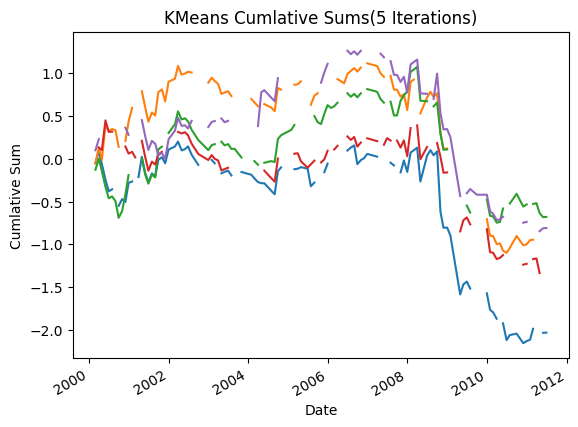

In [28]:
run_trading_KMeans_1('Monthly', max_months) # ~ 2 mins 30s

In [29]:
run_trading_KMeans_1('Weekly', max_weeks)

ValueError: at least one array or dtype is required

##### Spectral

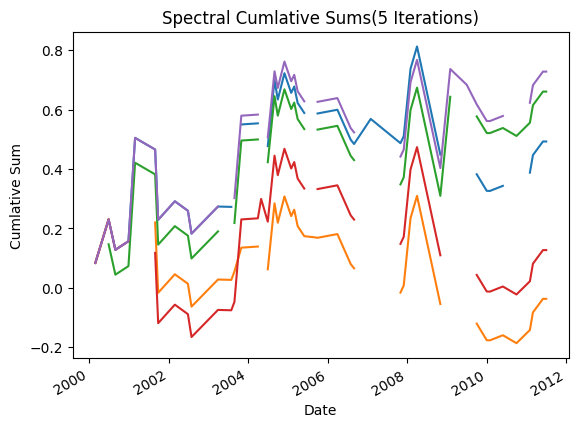

In [30]:
run_trading_Spectral('Monthly', max_months) # ~ 2 mins 35s

In [31]:
run_trading_Spectral('Weekly', max_weeks) 

ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by KMeans.

##### Hierarchial

In [34]:
import warnings
# Suppress the specific scipy warning about the distance matrix
warnings.filterwarnings(
    "ignore",
    message=".*The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix.*",
    category=UserWarning,
    module="sklearn.cluster._agglomerative"
)

In [35]:
run_trading_Hierarchial('Monthly', max_months)

ValueError: Input X contains NaN.
AgglomerativeClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [37]:
run_trading_Hierarchial('Weekly', max_weeks)

ValueError: at least one array or dtype is required

##### No Clustering

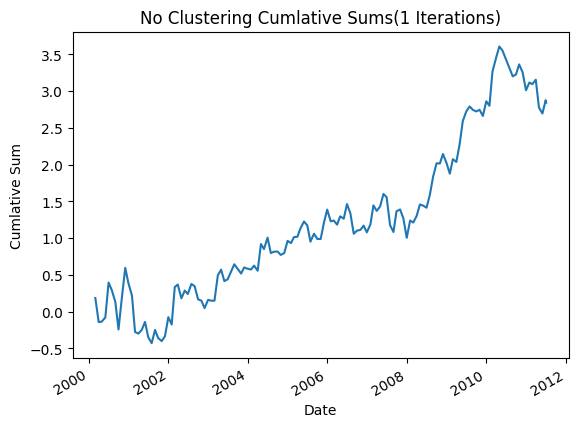

In [38]:
run_trading_noCluster('Monthly', 139)

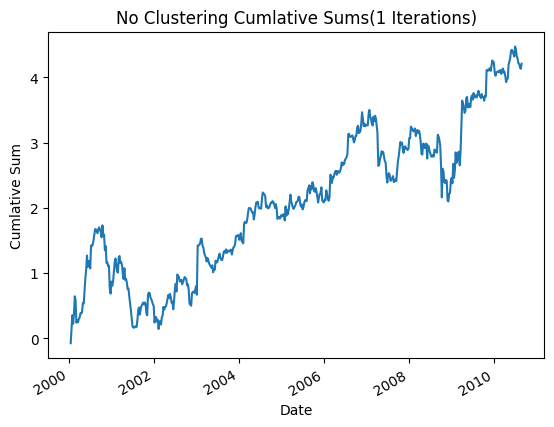

In [ ]:
run_trading_noCluster('Weekly', 556) # currently set to 1 iteration, check function def